# TheLook e-commerce business/marketing setting

A comprehensive analysis about the progress of the clothing e-commerce "TheLook". In particular, a study about the progress of sales, inventory and products.

The company data is stored in the following BigQuery database: bigquery-public-data.thelook_ecommerce.

## Import the necessary libraries

In [456]:
import requests
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import db_dtypes
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

## Rest API call to get daily exchange USD-EUR rate

In [457]:
# script to download current daily exchange USD-EUR rate

df_exchange = None
is_data_updated = None

if df_exchange is not None:
    today = date.today().strftime('%Y-%m-%d')

    if today == df_exchange.loc['msg']['date'] == today:
        is_data_updated = True

if not is_data_updated:
    url = 'https://api.exchangerate.host/latest'
    response = requests.get(url, params={'base':'USD'}, timeout=2)
    data = response.json()
    df_exchange = pd.DataFrame.from_dict(data)
    df_exchange.drop(columns=['motd','success'],inplace=True)
    df_exchange.reset_index(inplace=True)
    df_exchange.rename(columns={'index' : 'currency',
                                'rates' : 'rate'}, inplace=True)
    df_exchange = df_exchange[df_exchange['currency'] == 'EUR']
    df_exchange['date'] = pd.to_datetime(df_exchange['date'])
    df_exchange = df_exchange[~df_exchange.rate.isna()]
    
df_exchange

,currency,base,date,rate
48,EUR,USD,2023-08-09,0.910678


## Connect to Google BigQuery

In [458]:
credentials = service_account.Credentials.from_service_account_file(r'..\key.json')
project_id = 'the-look-ecommerce'
client = bigquery.Client(credentials= credentials,project=project_id)

## Database tables: importing, cleansing and wrangling the data

#### **Distribution_centers table:** importing, cleansing and wrangling the data

##### Import distribution_centers table from BigQuery

In [459]:
df_distribution_centers = client.query(
    "SELECT * "
    "FROM `bigquery-public-data.thelook_ecommerce.distribution_centers`"
).to_dataframe()

##### Exploring the data

In [460]:
df_distribution_centers.info() #check the data type of each column
df_distribution_centers #check the DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         10 non-null     Int64  
 1   name       10 non-null     object 
 2   latitude   10 non-null     float64
 3   longitude  10 non-null     float64
dtypes: Int64(1), float64(2), object(1)
memory usage: 462.0+ bytes


,id,name,latitude,longitude
0,1,Memphis TN,35.1174,-89.9711
1,2,Chicago IL,41.8369,-87.6847
2,3,Houston TX,29.7604,-95.3698
3,4,Los Angeles CA,34.0500,-118.2500
4,5,New Orleans LA,29.9500,-90.0667
5,6,Port Authority of New York/New Jersey NY/NJ,40.6340,-73.7834
6,7,Philadelphia PA,39.9500,-75.1667
7,8,Mobile AL,30.6944,-88.0431
8,9,Charleston SC,32.7833,-79.9333
9,10,Savannah GA,32.0167,-81.1167


##### Export the data as .xlsx

In [461]:
df_distribution_centers.to_excel('distribution_centers.xlsx', index = False, sheet_name='distribution_centers')

#### **Events table:** importing, cleansing and wrangling the data

##### Import events table from BigQuery


In [462]:
df_events = client.query(
    "SELECT id, user_id, session_id, city, state, created_at, browser, traffic_source, uri, event_type "
    "FROM `bigquery-public-data.thelook_ecommerce.events` "
).to_dataframe()

##### Exploring the data

In [463]:
df_events.info(show_counts=True) #check the data type of each column
df_events.head(5) #check the first 5 rows of the events table

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2427106 entries, 0 to 2427105
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype              
---  ------          --------------    -----              
 0   id              2427106 non-null  Int64              
 1   user_id         1303440 non-null  Int64              
 2   session_id      2427106 non-null  object             
 3   city            2427106 non-null  object             
 4   state           2427106 non-null  object             
 5   created_at      2427106 non-null  datetime64[ns, UTC]
 6   browser         2427106 non-null  object             
 7   traffic_source  2427106 non-null  object             
 8   uri             2427106 non-null  object             
 9   event_type      2427106 non-null  object             
dtypes: Int64(2), datetime64[ns, UTC](1), object(7)
memory usage: 189.8+ MB


,id,user_id,session_id,city,state,created_at,browser,traffic_source,uri,event_type
0,2234455,<NA>,66907bb8-98fc-464d-9f73-317cdfa82fdf,Bogatynia,Dolnośląskie,2019-12-29 18:18:00+00:00,Firefox,Facebook,/cart,cart
1,1648193,<NA>,40c2ef2d-0308-4aee-bed8-c5e33dc9ccd4,Bogatynia,Dolnośląskie,2020-04-29 13:14:00+00:00,Chrome,Organic,/cart,cart
2,2283499,<NA>,f2319388-38fc-4413-a9a8-dd6fc05352bf,Bogatynia,Dolnośląskie,2019-08-23 18:37:00+00:00,Chrome,Email,/cart,cart
3,1893975,<NA>,5f8b1c26-4af6-450a-a133-0e0f3433a9dc,Bogatynia,Dolnośląskie,2020-02-28 14:01:00+00:00,Other,Email,/cart,cart
4,1782112,<NA>,08dd2d62-816a-4120-87a0-3401e409c8c4,Bogatynia,Dolnośląskie,2021-06-03 06:48:00+00:00,Safari,Adwords,/cart,cart


##### Cleansing & wrangling the data

In [464]:
df_events['user_id'].fillna(-1, inplace=True) # replace all the null values in the user_id column with -1
print(df_events.info(show_counts=True)) # check if the tables have been cleaned properly (if there are no more null values)
df_events['user_id'] = df_events['user_id'].astype(str) # cast to string the user_id column
df_events.loc[df_events['user_id'] == '-1', 'user_id'] = 'not_registered' # replace the -1 values with not_registered
df_events.head(10) # check the result

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2427106 entries, 0 to 2427105
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype              
---  ------          --------------    -----              
 0   id              2427106 non-null  Int64              
 1   user_id         2427106 non-null  Int64              
 2   session_id      2427106 non-null  object             
 3   city            2427106 non-null  object             
 4   state           2427106 non-null  object             
 5   created_at      2427106 non-null  datetime64[ns, UTC]
 6   browser         2427106 non-null  object             
 7   traffic_source  2427106 non-null  object             
 8   uri             2427106 non-null  object             
 9   event_type      2427106 non-null  object             
dtypes: Int64(2), datetime64[ns, UTC](1), object(7)
memory usage: 189.8+ MB
None


,id,user_id,session_id,city,state,created_at,browser,traffic_source,uri,event_type
0,2234455,not_registered,66907bb8-98fc-464d-9f73-317cdfa82fdf,Bogatynia,Dolnośląskie,2019-12-29 18:18:00+00:00,Firefox,Facebook,/cart,cart
1,1648193,not_registered,40c2ef2d-0308-4aee-bed8-c5e33dc9ccd4,Bogatynia,Dolnośląskie,2020-04-29 13:14:00+00:00,Chrome,Organic,/cart,cart
2,2283499,not_registered,f2319388-38fc-4413-a9a8-dd6fc05352bf,Bogatynia,Dolnośląskie,2019-08-23 18:37:00+00:00,Chrome,Email,/cart,cart
3,1893975,not_registered,5f8b1c26-4af6-450a-a133-0e0f3433a9dc,Bogatynia,Dolnośląskie,2020-02-28 14:01:00+00:00,Other,Email,/cart,cart
4,1782112,not_registered,08dd2d62-816a-4120-87a0-3401e409c8c4,Bogatynia,Dolnośląskie,2021-06-03 06:48:00+00:00,Safari,Adwords,/cart,cart
5,1493377,not_registered,e9e36475-ebac-4bbd-a3c9-cc10d2686266,Bogatynia,Dolnośląskie,2019-03-11 02:13:00+00:00,Chrome,YouTube,/cart,cart
6,1514452,not_registered,d3c449b1-a221-4722-be0c-e4e555d7dcc6,Bogatynia,Dolnośląskie,2021-03-26 02:50:00+00:00,Chrome,Adwords,/cart,cart
7,360629,27542,46c1d259-3c57-4c09-8d9e-541dd934fd26,Gorzów Wielkopolski,Lubuskie,2023-05-31 11:13:33+00:00,Safari,Email,/cart,cart
8,496130,38212,b366104a-1b90-4455-8f10-35653921e00c,Gorzów Wielkopolski,Lubuskie,2022-06-11 05:28:39+00:00,Chrome,Facebook,/cart,cart
9,360619,27542,9561e55a-daa0-4458-8732-96b514e77d67,Gorzów Wielkopolski,Lubuskie,2023-05-31 10:05:13+00:00,Firefox,YouTube,/cart,cart


##### Analysis of the relation between events and users

In [465]:
# check the number of users that are not registered with regards to the total

not_registered_users = df_events.loc[df_events['user_id'] == 'not_registered', 'user_id'].count()
total_users = df_events['user_id'].count()
not_registered_users_prc = round((not_registered_users / total_users) *100,2)
print(f"there are {not_registered_users} not registered users out of {total_users} users, {not_registered_users_prc}% of the total")

there are 1123666 not registered users out of 2427106 users, 46.3% of the total


##### Export the data as .csv

In [466]:
df_events.to_csv('events.csv', index=False) #exported as a CSV and not XLSX due to size limit

#### **Users table:** importing, cleansing and wrangling the data

##### Import users table from BigQuery

In [467]:
df_users = client.query(
    "SELECT id, age, gender, state, country, traffic_source, created_at "
    "FROM `bigquery-public-data.thelook_ecommerce.users`"
).to_dataframe()

##### Exploring the data

In [468]:
df_users.info() #check the data type of each column
df_users.head() #check the first 5 rows of the events table

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   id              100000 non-null  Int64              
 1   age             100000 non-null  Int64              
 2   gender          100000 non-null  object             
 3   state           100000 non-null  object             
 4   country         100000 non-null  object             
 5   traffic_source  100000 non-null  object             
 6   created_at      100000 non-null  datetime64[ns, UTC]
dtypes: Int64(2), datetime64[ns, UTC](1), object(4)
memory usage: 5.5+ MB


,id,age,gender,state,country,traffic_source,created_at
0,9134,49,M,Acre,Brasil,Search,2022-09-03 00:40:00+00:00
1,42137,38,M,Acre,Brasil,Email,2019-12-22 08:54:00+00:00
2,57170,49,M,Acre,Brasil,Search,2023-05-20 16:59:00+00:00
3,62422,15,M,Acre,Brasil,Search,2020-04-29 02:43:00+00:00
4,94746,12,F,Acre,Brasil,Search,2019-08-10 06:12:00+00:00


##### Cleansing & wrangling the data

In [469]:
df_users['id'] = df_users['id'].astype(str) # cast to string the id column
df_users['created_at'] = pd.to_datetime(df_users["created_at"]).dt.date # cast to date the created_at column
df_users.head(5) # check the first 5 rows of the users table

,id,age,gender,state,country,traffic_source,created_at
0,9134,49,M,Acre,Brasil,Search,2022-09-03
1,42137,38,M,Acre,Brasil,Email,2019-12-22
2,57170,49,M,Acre,Brasil,Search,2023-05-20
3,62422,15,M,Acre,Brasil,Search,2020-04-29
4,94746,12,F,Acre,Brasil,Search,2019-08-10


##### Users age statistics

In [470]:
print('both genders')
df_users['age'].describe() # shows the age summary statistics of the users (both genders)


both genders


count     100000.0
mean      40.99358
std      16.978825
min           12.0
25%           26.0
50%           41.0
75%           56.0
max           70.0
Name: age, dtype: Float64

In [471]:
print('Male')
df_users[df_users['gender'] =='M']['age'].describe() # shows the age summary statistics of the users (male)

Male


count      50051.0
mean      41.02951
std      16.975401
min           12.0
25%           26.0
50%           41.0
75%           56.0
max           70.0
Name: age, dtype: Float64

In [472]:
print('Female')
df_users[df_users['gender'] =='F']['age'].describe() # shows the age summary statistics of the users (female)

Female


count      49949.0
mean     40.957577
std      16.982348
min           12.0
25%           26.0
50%           41.0
75%           56.0
max           70.0
Name: age, dtype: Float64

<Axes: xlabel='age', ylabel='gender'>

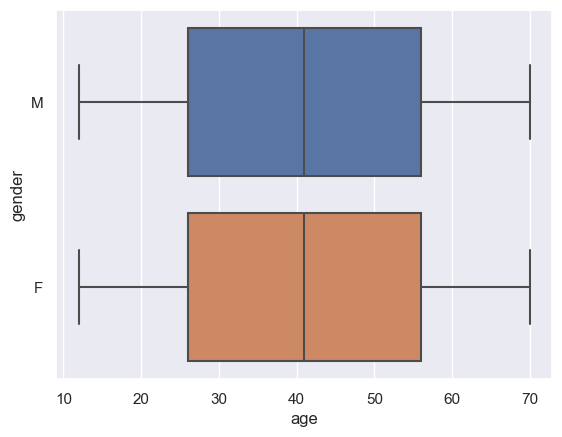

In [473]:
sns.boxplot(x='age', y='gender', data=df_users) # shows the distribution of user age by gender

##### Export the data as .xlsx

In [474]:
df_users.to_excel('users.xlsx', index=False, sheet_name='users')

#### **Inventory_items table:** importing, cleansing and wrangling the data

##### Import inventory_items table from BigQuery


In [475]:
df_inventory_items = client.query(
     "SELECT * "
    "FROM `bigquery-public-data.thelook_ecommerce.inventory_items`"
).to_dataframe()

##### Exploring the data

In [476]:
df_inventory_items.info() #check the data type of each column
df_inventory_items.head() #check the first 5 rows of the inventory_items table

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491224 entries, 0 to 491223
Data columns (total 12 columns):
 #   Column                          Non-Null Count   Dtype              
---  ------                          --------------   -----              
 0   id                              491224 non-null  Int64              
 1   product_id                      491224 non-null  Int64              
 2   created_at                      491224 non-null  datetime64[ns, UTC]
 3   sold_at                         181822 non-null  datetime64[ns, UTC]
 4   cost                            491224 non-null  float64            
 5   product_category                491224 non-null  object             
 6   product_name                    491224 non-null  object             
 7   product_brand                   491224 non-null  object             
 8   product_retail_price            491224 non-null  float64            
 9   product_department              491224 non-null  object             
 

,id,product_id,created_at,sold_at,cost,product_category,product_name,product_brand,product_retail_price,product_department,product_sku,product_distribution_center_id
0,10102,16898,2023-08-01 16:51:06+00:00,2023-08-03 04:07:06+00:00,13.925,Tops & Tees,Quiksilver Waterman Men's On The Rise,,25.0,Men,22811EE19846217512507785E74D12CC,3
1,10103,16898,2020-11-10 02:36:00+00:00,NaT,13.925,Tops & Tees,Quiksilver Waterman Men's On The Rise,,25.0,Men,22811EE19846217512507785E74D12CC,3
2,10104,16898,2020-05-22 09:46:00+00:00,NaT,13.925,Tops & Tees,Quiksilver Waterman Men's On The Rise,,25.0,Men,22811EE19846217512507785E74D12CC,3
3,36896,16898,2023-07-19 15:39:47+00:00,2023-08-09 09:54:47+00:00,13.925,Tops & Tees,Quiksilver Waterman Men's On The Rise,,25.0,Men,22811EE19846217512507785E74D12CC,3
4,36897,16898,2022-09-14 15:56:00+00:00,NaT,13.925,Tops & Tees,Quiksilver Waterman Men's On The Rise,,25.0,Men,22811EE19846217512507785E74D12CC,3


##### Cleansing & wrangling the data

In [477]:
df_inventory_items.rename(columns= {'cost' : 'cost_USD', 'product_retail_price' : 'product_retail_price_USD'}, inplace=True) #renaming currency columns as _USD
df_inventory_items["cost_EUR"] = df_inventory_items["cost_USD"] * df_exchange.loc[df_exchange["currency"] == "EUR","rate"].values[0] #adding cost_EUR column with USD-EUR conv. from API
df_inventory_items["product_retail_price_EUR"] = df_inventory_items["product_retail_price_USD"] * df_exchange.loc[df_exchange["currency"] == "EUR","rate"].values[0] #adding retail_price_EUR column with USD-EUR conv. from API
df_inventory_items['created_at'] = pd.to_datetime(df_inventory_items["created_at"]).dt.date #cast created_at column to date
df_inventory_items['sold_at'] = pd.to_datetime(df_inventory_items["sold_at"]).dt.date #cast sold_at column to date
df_inventory_items.info() #check the data type of each column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491224 entries, 0 to 491223
Data columns (total 14 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              491224 non-null  Int64  
 1   product_id                      491224 non-null  Int64  
 2   created_at                      491224 non-null  object 
 3   sold_at                         181822 non-null  object 
 4   cost_USD                        491224 non-null  float64
 5   product_category                491224 non-null  object 
 6   product_name                    491224 non-null  object 
 7   product_brand                   491224 non-null  object 
 8   product_retail_price_USD        491224 non-null  float64
 9   product_department              491224 non-null  object 
 10  product_sku                     491224 non-null  object 
 11  product_distribution_center_id  491224 non-null  Int64  
 12  cost_EUR        

##### Export the data as .xlsx

In [478]:
df_inventory_items.to_excel('inventory_items.xlsx', index=False, sheet_name='inventory_items')

#### **Products table:** importing, cleansing and wrangling the data

##### Import products table from BigQuery (all columns)

In [479]:
df_products = client.query(
    "SELECT * "
    "FROM `bigquery-public-data.thelook_ecommerce.products`"
).to_dataframe()

##### Exploring the data

In [480]:
df_products.info() #check the data type of each column
df_products.head() #check the first 5 rows of the products table

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29120 entries, 0 to 29119
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      29120 non-null  Int64  
 1   cost                    29120 non-null  float64
 2   category                29120 non-null  object 
 3   name                    29118 non-null  object 
 4   brand                   29096 non-null  object 
 5   retail_price            29120 non-null  float64
 6   department              29120 non-null  object 
 7   sku                     29120 non-null  object 
 8   distribution_center_id  29120 non-null  Int64  
dtypes: Int64(2), float64(2), object(5)
memory usage: 2.1+ MB


,id,cost,category,name,brand,retail_price,department,sku,distribution_center_id
0,27569,92.652563,Swim,2XU Men's Swimmers Compression Long Sleeve Top,2XU,150.410004,Men,B23C5765E165D83AA924FA8F13C05F25,1
1,27445,24.719661,Swim,TYR Sport Men's Square Leg Short Swim Suit,TYR,38.990002,Men,2AB7D3B23574C3DEA2BD278AFD0939AB,1
2,27457,15.897600,Swim,TYR Sport Men's Solid Durafast Jammer Swim Suit,TYR,27.600000,Men,8F831227B0EB6C6D09A0555531365933,1
3,27466,17.850000,Swim,TYR Sport Men's Swim Short/Resistance Short Sw...,TYR,30.000000,Men,67317D6DCC4CB778AEB9219565F5456B,1
4,27481,29.408001,Swim,TYR Alliance Team Splice Jammer,TYR,45.950001,Men,213C888198806EF1A0E2BBF2F4855C6C,1


##### Cleansing & wrangling the data

In [481]:
df_products.rename(columns= {'cost' : 'cost_USD',
                             'retail_price' : 'retail_price_USD'}, inplace=True) #renaming currency columns as _USD
df_products["retail_price_EUR"] = df_products["retail_price_USD"] * df_exchange.loc[df_exchange["currency"] == "EUR","rate"].values[0] #adding retail_price_EUR column with USD-EUR conv. from API
df_products["cost_EUR"] = df_products["cost_USD"] * df_exchange.loc[df_exchange["currency"] == "EUR","rate"].values[0] #adding cost_EUR column with USD-EUR conv. from API
df_products = df_products[['id', 'cost_USD','cost_EUR', 'category', 'name', 'brand', 'retail_price_USD','retail_price_EUR','department', 'sku', 'distribution_center_id']] #reordering columns
df_products['name'].fillna("Not specified",inplace=True) #fill_na for name column
df_products['brand'].fillna("Not specified",inplace=True) #fill_na for brand column
df_products['unit_margin_USD'] = df_products['retail_price_USD'] - df_products['cost_USD'] #adding unit_margin_USD column
df_products['unit_margin_EUR'] = df_products['retail_price_EUR'] - df_products['cost_EUR'] #adding unit_margin_EUR column
df_products['unit_margin_EUR_%'] = ((df_products['retail_price_EUR'] - df_products['cost_EUR']) / df_products['cost_EUR']) *100 #adding unit_margin_EUR_% column
df_products.head() #checking the output

,id,cost_USD,cost_EUR,category,name,brand,retail_price_USD,retail_price_EUR,department,sku,distribution_center_id,unit_margin_USD,unit_margin_EUR,unit_margin_EUR_%
0,27569,92.652563,84.376650,Swim,2XU Men's Swimmers Compression Long Sleeve Top,2XU,150.410004,136.975081,Men,B23C5765E165D83AA924FA8F13C05F25,1,57.757441,52.598431,62.337662
1,27445,24.719661,22.511652,Swim,TYR Sport Men's Square Leg Short Swim Suit,TYR,38.990002,35.507337,Men,2AB7D3B23574C3DEA2BD278AFD0939AB,1,14.270340,12.995685,57.728706
2,27457,15.897600,14.477595,Swim,TYR Sport Men's Solid Durafast Jammer Swim Suit,TYR,27.600000,25.134713,Men,8F831227B0EB6C6D09A0555531365933,1,11.702400,10.657118,73.611111
3,27466,17.850000,16.255602,Swim,TYR Sport Men's Swim Short/Resistance Short Sw...,TYR,30.000000,27.320340,Men,67317D6DCC4CB778AEB9219565F5456B,1,12.150000,11.064738,68.067226
4,27481,29.408001,26.781219,Swim,TYR Alliance Team Splice Jammer,TYR,45.950001,41.845655,Men,213C888198806EF1A0E2BBF2F4855C6C,1,16.542000,15.064436,56.250000


##### Analysis of the relation between df_products and df_inventory_items

In [482]:
df_inventory_items_in_stock = df_inventory_items[pd.isna(df_inventory_items['sold_at'])] #defining a variable with all the products available in the warehouses

print(f'count distinct df_inventory_items in stock: {df_inventory_items_in_stock.product_id.nunique()}') #count distinct product in stock
print(f'count distinct df_products id: {df_products.id.nunique()}') #count distinct products master data

wh_item_in_products_table = df_inventory_items_in_stock[df_inventory_items_in_stock['product_id'].isin(df_products['id'])]['product_id'].nunique() #defining a variable to vlookup in stock materials into products master data
wh_item_not_in_products_table = df_inventory_items_in_stock[~df_inventory_items_in_stock['product_id'].isin(df_products['id'])]['product_id'].nunique() #defining a variable to ~ vlookup in stock materials into products master data

products_in_wh = df_products[df_products['id'].isin(df_inventory_items_in_stock['product_id'])]['id'].nunique() #defining a variable to vlookup products master data into in stock materials 
products_not_in_wh = df_products[~df_products['id'].isin(df_inventory_items_in_stock['product_id'])]['id'].nunique() #defining a variable to ~ vlookup products master data into in stock materials 


# if statement to assess if there are warehouse products without a relative master data
if wh_item_not_in_products_table == 0:
    print('all the warehouse products have a match in products_table')
else:
    print('warehouse products not in products_table:', wh_item_not_in_products_table)


# if statement to assess out of stock products
if products_not_in_wh == 0:
    print('all the products have been stored in the warehouses')
else:
    print('out of stock products in the warehouses:', products_not_in_wh)


count distinct df_inventory_items in stock: 29047
count distinct df_products id: 29120
all the warehouse products have a match in products_table
out of stock products in the warehouses: 73


##### Additional data wrangling

In [483]:
df_products['in_stock'] = ['yes' if id in df_inventory_items_in_stock['product_id'].values else 'no' for id in df_products['id']] #adding 'in stock' column to products table
df_products[df_products['in_stock'] == 'no']['in_stock'].count() #checking the number of out of stock products

73

##### Retail price analysis

retail_price analysis:


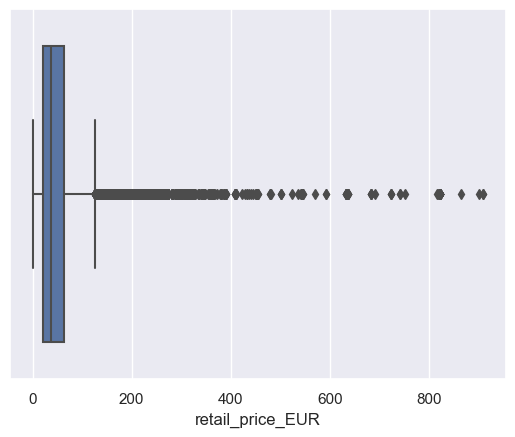

count    29120.000000
mean        53.930500
std         60.003596
min          0.018214
25%         21.856272
50%         36.418015
75%         63.701923
max        909.767322
Name: retail_price_EUR, dtype: float64

In [484]:
print("retail_price analysis:")
sns.boxplot(data=df_products, x='retail_price_EUR')
plt.show()
df_products['retail_price_EUR'].describe()

In [485]:
#A more in-depth analysis is required to determine the minimum value that can be considered an outlier.

df_products[df_products['retail_price_EUR'] == df_products['retail_price_EUR'].min()]

,id,cost_USD,cost_EUR,category,name,brand,retail_price_USD,retail_price_EUR,department,sku,distribution_center_id,unit_margin_USD,unit_margin_EUR,unit_margin_EUR_%,in_stock
23267,14235,0.0083,0.007559,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,0.018214,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,0.0117,0.010655,140.963856,yes


In [486]:
#how many products with retail price < 1€? 

df_products[df_products['retail_price_EUR'] < 1]

#I have decided to keep the IDs since their cost, retail price, and margin appear to be coherent with one another.

,id,cost_USD,cost_EUR,category,name,brand,retail_price_USD,retail_price_EUR,department,sku,distribution_center_id,unit_margin_USD,unit_margin_EUR,unit_margin_EUR_%,in_stock
23267,14235,0.00830,0.007559,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,0.018214,Women,8425BC94A44E3D1BB3C8C026B2702C00,1,0.01170,0.010655,140.963856,yes
23317,14159,0.17738,0.161536,Accessories,Set of 2 - Replacement Insert For Checkbook Wa...,Made in USA,0.49,0.446232,Women,C92B32FBC94E2DFF3E5516401D9BB463,1,0.31262,0.284696,176.243094,yes


##### Cost analysis

Cost analysis:


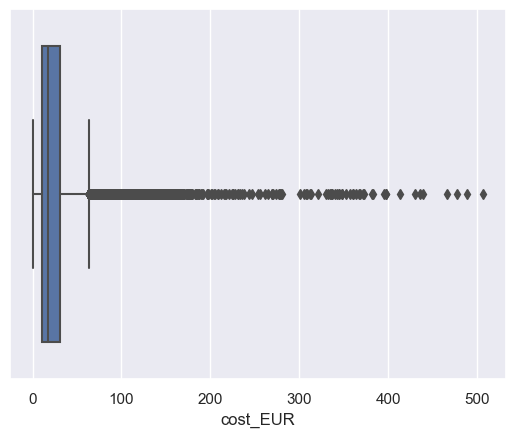

count    29120.000000
mean        25.937725
std         27.889223
min          0.007559
25%         10.268453
50%         17.917663
75%         31.363750
max        507.385160
Name: cost_EUR, dtype: float64

In [487]:
print("Cost analysis:")
sns.boxplot(data=df_products, x='cost_EUR')
plt.show()
df_products['cost_EUR'].describe()

##### Margin analysis

Margin analysis:


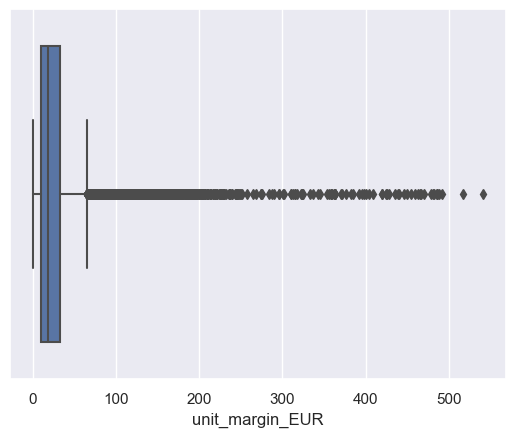

count    29120.000000
mean        27.992775
std         33.013363
min          0.010655
25%         10.570998
50%         18.267946
75%         32.638699
max        541.311556
Name: unit_margin_EUR, dtype: float64

In [488]:
print("Margin analysis:")
sns.boxplot(data=df_products, x='unit_margin_EUR')
plt.show()
df_products['unit_margin_EUR'].describe()

##### Category analysis


In [489]:
df_products.groupby('category')['retail_price_EUR'].describe().T

category,Accessories,Active,Blazers & Jackets,Clothing Sets,Dresses,Fashion Hoodies & Sweatshirts,Intimates,Jeans,Jumpsuits & Rompers,Leggings,...,Skirts,Sleep & Lounge,Socks,Socks & Hosiery,Suits,Suits & Sport Coats,Sweaters,Swim,Tops & Tees,Underwear
count,1559.000000,1432.000000,561.000000,37.000000,955.000000,1866.000000,2363.000000,1999.000000,162.000000,564.000000,...,367.000000,1771.000000,905.000000,666.000000,188.000000,739.000000,1737.000000,1798.000000,1868.000000,1088.000000
mean,38.763298,46.099449,84.324303,77.265614,76.682073,49.099746,30.696570,89.112763,41.364962,24.724601,...,47.651437,44.822450,18.600533,15.262922,105.788086,115.251415,68.591339,52.651451,37.648920,24.730373
std,43.875086,68.929591,84.010434,38.494709,74.078991,33.096089,27.451765,58.143624,56.758015,31.006745,...,56.028601,37.834640,39.195594,10.280152,42.156253,89.948563,53.571765,32.588867,30.113025,13.655123
min,0.018214,1.775822,6.994007,18.204453,7.276317,8.086821,1.593687,9.097673,7.959326,4.544283,...,5.910300,2.722927,2.722927,1.775822,12.740385,9.097673,5.454961,5.418534,2.832208,5.454961
25%,12.034609,20.034916,18.022318,52.810219,30.034160,31.828197,15.026187,41.686285,11.854751,9.493818,...,21.842612,22.766950,10.928136,9.106780,75.914119,50.956987,32.766194,31.864625,20.699711,18.213560
50%,22.129475,30.944838,54.631575,63.747460,53.730002,45.078561,25.498984,71.032884,22.716862,15.435993,...,33.685981,33.685981,13.733024,12.749492,111.749297,90.612461,53.720897,45.524795,27.989688,22.766950
75%,44.623222,50.087290,118.388140,100.165471,98.808563,59.046083,38.248476,129.293508,44.224800,27.311233,...,54.604254,54.640680,20.034916,18.204453,132.533247,159.368650,86.514410,61.923827,45.078561,27.320340
max,272.292722,822.342234,635.653244,182.090063,453.517644,822.342234,822.342234,354.253742,500.872900,481.575631,...,544.585444,364.225677,822.342234,145.662943,218.307731,635.653244,535.478664,262.275264,259.543230,258.031501


##### Export the data as .xlsx

In [490]:
df_products.to_excel('products.xlsx', index=False, sheet_name='products')

#### **Orders table:** importing, cleansing and wrangling the datas

##### Import orders table from BigQuery

In [491]:
df_orders = client.query("SELECT * FROM `bigquery-public-data.thelook_ecommerce.orders`").to_dataframe()

##### Exploring the data

In [492]:
df_orders.info() #check the data type of each column
df_orders.head() #check the first 5 rows of the inventory_items table

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125281 entries, 0 to 125280
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   order_id      125281 non-null  Int64              
 1   user_id       125281 non-null  Int64              
 2   status        125281 non-null  object             
 3   gender        125281 non-null  object             
 4   created_at    125281 non-null  datetime64[ns, UTC]
 5   returned_at   12713 non-null   datetime64[ns, UTC]
 6   shipped_at    81196 non-null   datetime64[ns, UTC]
 7   delivered_at  43826 non-null   datetime64[ns, UTC]
 8   num_of_item   125281 non-null  Int64              
dtypes: Int64(3), datetime64[ns, UTC](4), object(2)
memory usage: 9.0+ MB


,order_id,user_id,status,gender,created_at,returned_at,shipped_at,delivered_at,num_of_item
0,17,15,Shipped,F,2023-05-26 02:33:00+00:00,NaT,2023-05-26 16:32:00+00:00,NaT,1
1,30,25,Shipped,F,2022-09-19 09:49:00+00:00,NaT,2022-09-20 00:29:00+00:00,NaT,1
2,37,31,Shipped,F,2021-06-15 14:36:00+00:00,NaT,2021-06-18 05:50:00+00:00,NaT,1
3,41,35,Shipped,F,2022-12-03 06:50:00+00:00,NaT,2022-12-03 15:06:00+00:00,NaT,1
4,56,46,Shipped,F,2021-11-07 08:14:00+00:00,NaT,2021-11-09 22:01:00+00:00,NaT,1


##### Cleansing & wrangling the data

In [493]:
df_orders['user_id'] = df_orders['user_id'].astype(str) #change data type of user_id to string
df_orders['created_at'] = pd.to_datetime(df_orders["created_at"]).dt.date #cast to date the created_at column
df_orders['returned_at'] = pd.to_datetime(df_orders["returned_at"]).dt.date #cast to date the returned_at column
df_orders['shipped_at'] = pd.to_datetime(df_orders["shipped_at"]).dt.date #cast to date the shipped_at column
df_orders['delivered_at'] = pd.to_datetime(df_orders["delivered_at"]).dt.date #cast to date the delivered_at column

daily_order_counts = df_orders.groupby('created_at').size() #Group the DataFrame by date and count the number of orders for each date

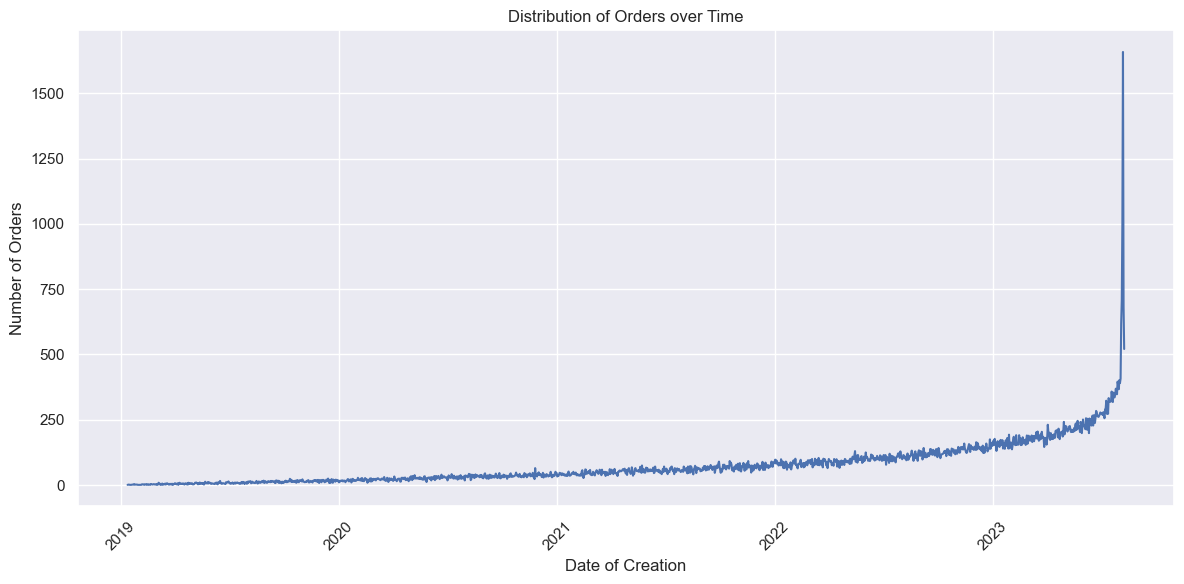

In [494]:
# Create a line graph for the distribution of orders over time.

plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_order_counts)
plt.title('Distribution of Orders over Time')
plt.xlabel('Date of Creation')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [495]:
"""
Due to the daily updates in the GoogleQuery Database, during the last refresh, I noticed a significant spike observed from August 1st, 2023.
Consequently, I am conducting an analysis focusing on this specific period to better understand the nature of the spike."
"""

start_date = date(2023, 7, 31) #Define the start date from which you want to exclude data.
filtered_df = df_orders[df_orders['created_at'] > start_date] #Filter data to keep only those after the start date.
filtered_df['created_at'].min() #Check if the filtered_df is filtered correctly


datetime.date(2023, 8, 1)

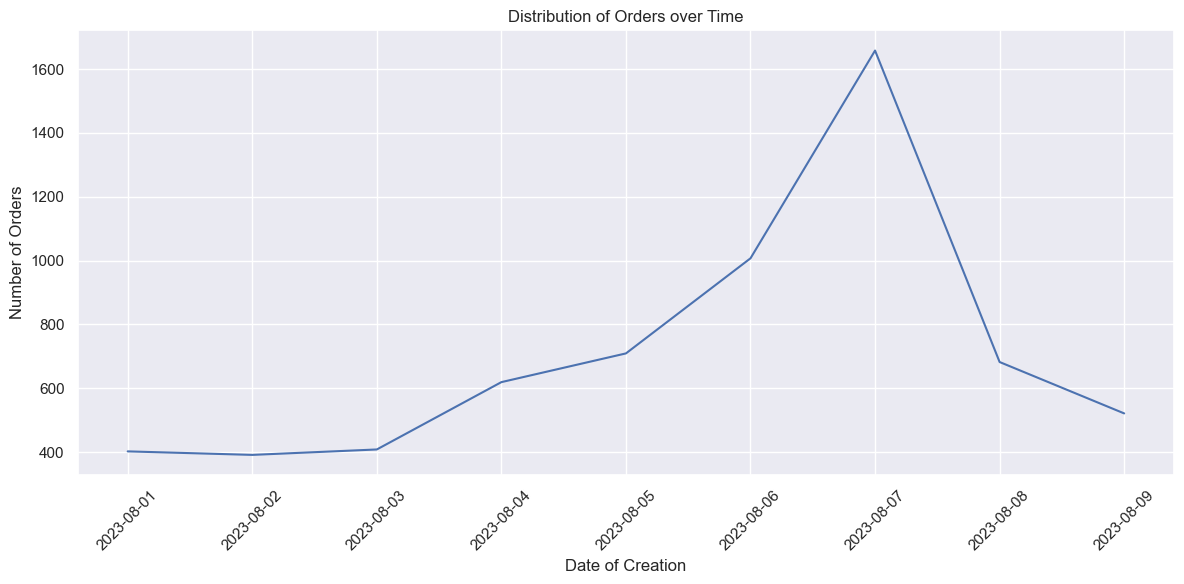

'\nIt seems that the spike is accurate and not an error, as the growth seems to be consistent day by day. \nHowever, it seems that the two days preceding the current date are not updated in real-time, \nbut rather Google BigQuery updates orders for the days just below the current date with a delay. \nTherefore, in Tableau, we will exclude the entire month of August (start date = 2023-07-31) \nto have a static view of the first seven month of 2023.\n'

In [496]:
daily_order_counts_filtered = filtered_df.groupby('created_at').size() # Group the DataFrame by date and count the number of orders for each date

# Create a line graph for the distribution of orders over time.
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_order_counts_filtered)
plt.title('Distribution of Orders over Time')
plt.xlabel('Date of Creation')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

"""
It seems that the spike is accurate and not an error, as the growth seems to be consistent day by day. 
However, it seems that the two days preceding the current date are not updated in real-time, 
but rather Google BigQuery updates orders for the days just below the current date with a delay. 
Therefore, in Tableau, we will exclude the entire month of August (start date = 2023-07-31) 
to have a static view of the first seven month of 2023.
"""

##### Export the data as .xlsx

In [497]:
df_orders.to_excel('orders.xlsx', index=False, sheet_name='orders')

#### **Order_items table:** importing, cleansing and wrangling the datas

##### Import order_items table from BigQuery

In [498]:
df_order_items = client.query(
    "SELECT id, order_id, user_id, product_id, inventory_item_id, status, created_at, shipped_at, delivered_at, returned_at, sale_price "
    "FROM `bigquery-public-data.thelook_ecommerce.order_items`"
).to_dataframe()

##### Exploring the data

In [499]:
df_order_items.info() #check the data type of each column
df_order_items.head() #check the first 5 rows of the df_order_items table

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181822 entries, 0 to 181821
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   id                 181822 non-null  Int64              
 1   order_id           181822 non-null  Int64              
 2   user_id            181822 non-null  Int64              
 3   product_id         181822 non-null  Int64              
 4   inventory_item_id  181822 non-null  Int64              
 5   status             181822 non-null  object             
 6   created_at         181822 non-null  datetime64[ns, UTC]
 7   shipped_at         117721 non-null  datetime64[ns, UTC]
 8   delivered_at       63452 non-null   datetime64[ns, UTC]
 9   returned_at        18376 non-null   datetime64[ns, UTC]
 10  sale_price         181822 non-null  float64            
dtypes: Int64(5), datetime64[ns, UTC](4), float64(1), object(1)
memory usage: 16.1+ MB


,id,order_id,user_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price
0,137867,95042,76027,13606,372564,Shipped,2023-07-16 09:26:46+00:00,2023-07-17 14:11:00+00:00,NaT,NaT,2.5
1,55852,38368,30728,13606,151095,Cancelled,2023-06-23 17:23:37+00:00,NaT,NaT,NaT,2.5
2,71330,49142,39346,13606,192943,Cancelled,2021-10-20 07:22:23+00:00,NaT,NaT,NaT,2.5
3,99725,68611,54904,13606,269504,Cancelled,2023-06-02 10:44:05+00:00,NaT,NaT,NaT,2.5
4,154277,106324,84986,13606,416871,Cancelled,2021-09-28 06:06:10+00:00,NaT,NaT,NaT,2.5


##### Cleansing & wrangling the data

In [500]:
df_order_items.rename(columns= {'sale_price' : 'sale_price_USD'}, inplace=True) #renaming currency columns as _USD
df_order_items["sale_price_EUR"] = df_order_items["sale_price_USD"] * df_exchange.loc[df_exchange["currency"] == "EUR","rate"].values[0] #adding retail_price_EUR column with USD-EUR conv. from API
df_order_items['created_at'] = pd.to_datetime(df_order_items["created_at"]).dt.date #cast to date the created_at column
df_order_items['returned_at'] = pd.to_datetime(df_order_items["returned_at"]).dt.date #cast to date the returned_at column
df_order_items['shipped_at'] = pd.to_datetime(df_order_items["shipped_at"]).dt.date #cast to date the shipped_at column
df_order_items['delivered_at'] = pd.to_datetime(df_order_items["delivered_at"]).dt.date #cast to date the delivered_at column
df_order_items['shipping_duration'] = df_order_items['delivered_at'] - df_order_items['shipped_at'] #add a column to calculate shipping time

df_order_items.info() #check the data type of each column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181822 entries, 0 to 181821
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 181822 non-null  Int64  
 1   order_id           181822 non-null  Int64  
 2   user_id            181822 non-null  Int64  
 3   product_id         181822 non-null  Int64  
 4   inventory_item_id  181822 non-null  Int64  
 5   status             181822 non-null  object 
 6   created_at         181822 non-null  object 
 7   shipped_at         117721 non-null  object 
 8   delivered_at       63452 non-null   object 
 9   returned_at        18376 non-null   object 
 10  sale_price_USD     181822 non-null  float64
 11  sale_price_EUR     181822 non-null  float64
 12  shipping_duration  63452 non-null   object 
dtypes: Int64(5), float64(2), object(6)
memory usage: 18.9+ MB


In [501]:
df_order_items.describe() #use describe method to have statistic insights of all the numeric columns

,id,order_id,user_id,product_id,inventory_item_id,sale_price_USD,sale_price_EUR
count,181822.0,181822.0,181822.0,181822.0,181822.0,181822.000000,181822.000000
mean,90911.5,62600.990276,50062.902988,15283.001023,245706.328574,59.440843,54.131468
std,52487.63466,36205.553822,28902.263559,8417.27936,141817.932622,66.174963,60.264083
min,1.0,1.0,1.0,1.0,2.0,0.020000,0.018214
25%,45456.25,31164.0,24898.0,7991.0,122942.75,24.500000,22.311611
50%,90911.5,62556.5,50017.5,15995.0,245721.0,39.990002,36.418015
75%,136366.75,94033.75,75223.75,22564.0,368489.0,69.949997,63.701923
max,181822.0,125281.0,100000.0,29120.0,491224.0,999.000000,909.767322


##### Export the data as .xlsx

In [502]:
df_order_items.to_excel('order_items.xlsx', index=False, sheet_name='order_items')

## Basic Machine Learning

#### **Linear Regression**

##### Defining regression scope

I thought that analyzing categories with the highest profit margins could provide valuable insights. My goal was to find correlations with user's data and perform a regression that could help top management to better target marketing campaigns, ultimately leading to increased revenue. 

##### Cleansing & wrangling the data

In [503]:
#changing data type to df_users.id to allow merge
df_users['id'] = pd.to_numeric(df_users['id']).astype('Int64') 

#creating a ML_df with df_order_items, df_users and df_products
ML_df = df_order_items[['user_id','product_id']].merge(right=df_users[['id', 'age','gender','country','traffic_source']], left_on='user_id', right_on='id', how='inner')\
.merge(right=df_products[['id', 'category','unit_margin_EUR_%']], left_on='product_id', right_on='id', how='inner').drop(columns=['user_id','id_x','id_y','product_id'])
ML_df.head()



,age,gender,country,traffic_source,category,unit_margin_EUR_%
0,62,F,Japan,Facebook,Accessories,125.733634
1,24,F,Australia,Organic,Accessories,125.733634
2,67,F,China,Email,Accessories,125.733634
3,52,F,China,Search,Accessories,125.733634
4,17,F,China,Search,Accessories,125.733634


In [504]:
#defining 3 best categories per margin
df_products.groupby('category', as_index=False)[['unit_margin_EUR','unit_margin_EUR_%']].mean().sort_values(by=['unit_margin_EUR'], ascending=False).head(3) 

,category,unit_margin_EUR,unit_margin_EUR_%
11,Outerwear & Coats,73.800101,125.556579
21,Suits & Sport Coats,68.989310,150.869557
2,Blazers & Jackets,52.349445,164.676598


In [505]:
#Boolean masking to filter only the rows that belong to the three chosen categories
ML_df = ML_df[ML_df['category'].isin(['Outerwear & Coats', 'Suits & Sport Coats', 'Blazers & Jackets'])] 
ML_df.loc[ML_df['country'] == 'España','country'] = 'Spain' #cleansing country values

#Ingesting a CSV with GDP data related to all world countries
GDP = pd.read_csv('C:/Users/VISMAS01/OneDrive - Heineken International/Personale/Formazione/Boolean Data Analytics 2023/Capstone Project/Data file/gdp_csv.csv')
GDP = GDP[GDP['Year'] == GDP['Year'].max()] #keeping only last year available (closer to Dataset years)

#Creating a function to return a country_code based on country_name
def get_country_code(country): 
    country_code_mapping = {
        'Australia': 'AUS',
        'Brasil': 'BRA',
        'United States': 'USA',
        'Germany': 'DEU',
        'China' : 'CHN',
        'France' : 'FRA',
        'Spain' : 'ESP',
        'South Korea' : 'KOR',
        'United Kingdom' : 'GBR',
        'Japan' : 'JPN',
        'Belgium' : 'BEL',
        'Colombia' : 'COL',
        'Poland' : 'POL'     
    }
    return country_code_mapping.get(country, '')

#Creating a new column with country_code retrieved with the above function
ML_df['country_code'] = ML_df['country'].apply(get_country_code) 
ML_df.head() #checking the DataFrame

,age,gender,country,traffic_source,category,unit_margin_EUR_%,country_code
145,25,M,China,Email,Suits & Sport Coats,160.416668,CHN
146,38,M,United Kingdom,Facebook,Suits & Sport Coats,160.416668,GBR
147,53,M,United States,Organic,Suits & Sport Coats,160.416668,USA
148,61,M,France,Search,Suits & Sport Coats,160.416668,FRA
149,16,M,Japan,Search,Suits & Sport Coats,160.416668,JPN


In [506]:
#Merging GDP DataFrame with ML_df to maintain only ML_df countries
GDP = GDP.merge(right=ML_df['country_code'], left_on='Country Code', right_on='country_code', how='inner')

#Creating a country_GDP DataFrame to rank countries into 2 clusters
country_GDP = GDP.groupby('country_code',as_index=False).agg({'Value': 'max'}).sort_values(by='Value', ascending=False).reset_index()
median_value = country_GDP['Value'].median()
country_GDP['GDP_clusters'] = ['High' if GDP > median_value else 'Low' for GDP in country_GDP['Value']]
country_GDP.drop(columns=['index'])

#Merging ML_df with country_GDP DataFrame, to get GDP_clusters column
ML_df = ML_df.merge(right=country_GDP[['country_code','GDP_clusters']], left_on='country_code', right_on='country_code', how='inner').drop(columns=['country_code'])
ML_df.head()


,age,gender,country,traffic_source,category,unit_margin_EUR_%,GDP_clusters
0,25,M,China,Email,Suits & Sport Coats,160.416668,High
1,55,M,China,Search,Suits & Sport Coats,160.416668,High
2,37,M,China,Search,Suits & Sport Coats,160.416668,High
3,42,M,China,Organic,Suits & Sport Coats,160.416668,High
4,16,M,China,Organic,Suits & Sport Coats,160.416668,High


In [507]:
#create a copy of the ML_df DataFrame to prepare data for ML model
dummy_ML_df = ML_df.copy()

#defining dict to store values of dummy values
dict_gender = {'M' : 1,'F' : 0}
dict_category = {'Outerwear & Coats' : 1, 'Suits & Sport Coats': 2, 'Blazers & Jackets' : 0}
dict_GDP_clusters = {'High' : 1, 'Low' : 0}

#creating dummy columns for different columns
dummy_ML_df['dummy_category'] = [1 if row == 'Outerwear & Coats'  else 2 if row == 'Suits & Sport Coats' else 0 for row in dummy_ML_df['category']]
dummy_ML_df['dummy_gender'] = [1 if row == 'M' else 0 for row in dummy_ML_df['gender']]
dummy_ML_df['dummy_GDP_clusters'] = [1 if row == 'High' else 0 for row in dummy_ML_df['GDP_clusters']]
dummy_ML_df = pd.get_dummies(dummy_ML_df, columns=['traffic_source'])

#creating a function to divide age in 2 clusters, since there was no correlation between top 3 categories and age or 6 clusters.
def create_age_cluster(age): 
    if age <= 20:
        return 0
    elif age <= 30:
        return 0
    elif age <= 40:
        return 0
    elif age <= 50:
        return 1
    elif age <= 60:
        return 1
    else:
        return 1
dummy_ML_df['age_clusters'] = dummy_ML_df['age'].apply(create_age_cluster)

#dropping original columns
dummy_ML_df.drop(columns=['country','gender','category','GDP_clusters'],inplace=True)


In [508]:
#checking dummy_ML_df DataFrame
dummy_ML_df.head()

,age,unit_margin_EUR_%,dummy_category,dummy_gender,dummy_GDP_clusters,traffic_source_Display,traffic_source_Email,traffic_source_Facebook,traffic_source_Organic,traffic_source_Search,age_clusters
0,25,160.416668,2,1,1,False,True,False,False,False,0
1,55,160.416668,2,1,1,False,False,False,False,True,1
2,37,160.416668,2,1,1,False,False,False,False,True,0
3,42,160.416668,2,1,1,False,False,False,True,False,1
4,16,160.416668,2,1,1,False,False,False,True,False,0


In [509]:
#analyzing correlations to dummy_category (defined target)
Correlations = dummy_ML_df.corr()
Correlations['dummy_category']

age                        0.014000
unit_margin_EUR_%         -0.072762
dummy_category             1.000000
dummy_gender               0.681525
dummy_GDP_clusters        -0.004364
traffic_source_Display    -0.010158
traffic_source_Email      -0.003665
traffic_source_Facebook    0.002524
traffic_source_Organic     0.012275
traffic_source_Search     -0.004676
age_clusters               0.012217
Name: dummy_category, dtype: float64

##### Outcome

After conducting the analysis (as detailed above), I realized that there is no significant correlation between the top 3 product categories based on profit margin and the following user data:

- User's age (as an individual value)
- Age clusters (both as decade-based clusters and over/under 50)
- User's country
- Country GDP clusters (categorized as countries with "high GDP" and "Low GDP")
- Traffic source

The only noteworthy correlation I managed to identify was with user's gender (0.67). However, I believe this correlation might not be strong enough to effectively train and test any machine learning model, especially considering that gender is a boolean field.

While we plan to deep dive in the future to discover more meaningful correlations, for now, I recommend considering the absence of significant correlations as a preliminary insight.
